In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import fftconvolve
import IPython
import pyroomacoustics as pra
from glob import glob
import scipy as sp
import torch
import h5py


In [81]:
batch_simulate_at_same_locations = 25



# constants
sample_length = 10000
extra_bit = 1000

reflection_coeff = 0.5
scatter_coeff = 0.15

speed_of_sound = 343


fs = 16000
max_freq = 4000
max_freq_component_to_use = int(max_freq/(fs/sample_length))



In [128]:

n_rooms = 20
n_mics = 50 
rir_len = 1600

fs = 16000

# X = np.zeros((n_rooms,n_mics,rir_len))
# Y = np.zeros((n_rooms,n_mics))

with h5py.File("../datasets/generated_dataset/new_type_dataset_medium.hdf5","w") as hdf5_file:
    X = hdf5_file.create_dataset("input", (n_rooms,n_mics,rir_len), dtype="f")
    Y = hdf5_file.create_dataset("gt", (n_rooms,n_mics), dtype="f")
    




    for room_i in range(n_rooms):
        # randomly generate a rectangular cuboid
        x,y,z = 9*np.random.rand(3) + 1
        corners = np.array([[0,0], [0,y], [x,y], [x,0]]).T 
        room = pra.Room.from_corners(corners, fs=fs, max_order=2, materials=pra.Material(reflection_coeff, scatter_coeff), ray_tracing=True, air_absorption=True)
        room.extrude(z, materials=pra.Material(reflection_coeff, scatter_coeff))
        room.set_ray_tracing(receiver_radius=0.2, n_rays=10000, energy_thres=1e-5)

        #add sender and receivers to room
        random_point_in_room = lambda : np.random.rand(3)*[x,y,z]
        sender_position = random_point_in_room()
        room.add_source(sender_position)
        R = np.array(np.stack([random_point_in_room() for i in range(n_mics)]).T)
        room.add_microphone(R)
        
        # compute image sources for reflections
        room.image_source_model()
        room.compute_rir()

        for mic_i in range(n_mics):
            if len(room.rir[mic_i][0]) > rir_len:
                X[room_i,mic_i] = room.rir[mic_i][0][:rir_len]
                Y[room_i,mic_i] = np.linalg.norm(sender_position - R[:,mic_i])
            else:
                X[room_i,mic_i,:len(room.rir[mic_i][0])] = room.rir[mic_i][0]
                Y[room_i,mic_i] = np.linalg.norm(sender_position - R[:,mic_i])
            

In [377]:
max_freq = int(4000 * sample_length/fs)

f =  h5py.File("../datasets/generated_dataset/new_type_dataset_medium.hdf5","r")

Xall = f["input"]
yall = f["gt"]


rooms_per_batch = 8
mics_per_batch = 17 # pick odd number
X = Xall[2:2+rooms_per_batch,:mics_per_batch,:]


y = torch.tensor(yall[2:2+rooms_per_batch,:mics_per_batch])
X = torch.tensor(X).to("cpu")

#pull a random sound
sound_paths = glob("../datasets/reference_sounds/*.wav")
sound_path = sound_paths[np.random.randint(len(sound_paths))]
fs,signal = wavfile.read(sound_path)
start = np.random.randint(0,len(signal) - sample_length - rir_len-1, rooms_per_batch)
# simulate longer sound and then cut to the relevant piece
signals = np.zeros((rooms_per_batch, sample_length + rir_len-1))
for i in range(rooms_per_batch):
    signals[i,:] = signal[start[i]:start[i]  + sample_length + rir_len-1]
signals = torch.tensor(signals).to(torch.float32).to("cpu").unsqueeze(1)


#plt.plot(np.convolve(X[0],signal))
#plt.plot(signal + 2*max(signal))

#torch.nn.functional.conv1d(signal.unsqueeze(1),X.unsqueeze(1))
#ex1 = torch.fft.rfft(torch.concatenate([torch.zeros(rir_len),torch.ones(sample_length),torch.zeros(rir_len)]))*torch.fft.rfft(X,signal.shape[1]) * torch.fft.rfft(signal)


q = torch.fft.rfft(torch.fft.irfft(torch.fft.rfft(signals)*torch.fft.rfft(X,signals.shape[1]))[:,:,:sample_length])[:,:,:max_freq]
q = torch.concatenate([torch.concatenate([q,q.roll(i+1, 1)], dim=2) for i in range(mics_per_batch // 2)],dim=1)
q = q.view(rooms_per_batch*(mics_per_batch*(mics_per_batch - 1 ))//2, -1)
q = torch.concatenate([q.real,q.imag],dim=1)
y = torch.concatenate([y - y.roll(i+1,1) for i in range(mics_per_batch//2)],dim=1).view(-1).shape

#q = q.repeat(mics_per_batch-1,1,1,1)


#signals.shape
#X.shape
#ex2 = torch.fft.rfft(torch.nn.functional.conv1d(signals,X.view(rooms_per_batch*mics_per_batch,-1)))[:,:,:max_freq]


# (y.unsqueeze(0) - y.unsqueeze(1))

# ex2.shape 

(1.0, 500.0)

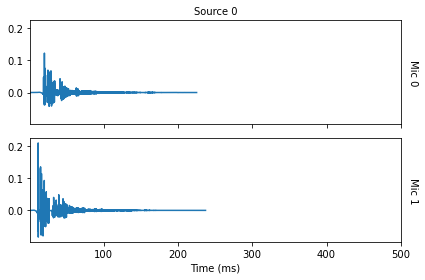

In [83]:



room.plot_rir()
room.rir[0][0].shape
plt.xlim(1,500)

304

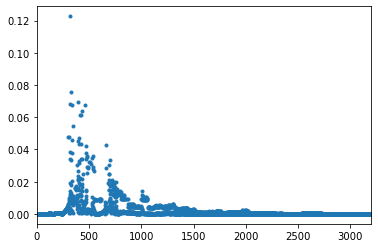

In [84]:
plt.plot(np.abs(room.rir[0][0]),'.')
plt.xlim(0,3200)
np.argmax(np.abs(room.rir[0][0]) > 1e-2)

In [61]:
s = np.convolve(signal,room.rir[0][0])
#signal.



In [67]:
sp.fft.fft(room.rir[0][0])

(17937,)

In [57]:

#simulate room
room.simulate()

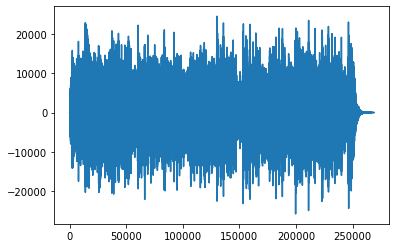

In [65]:
#plt.plot(room.mic_array.signals[0])